<a href="https://colab.research.google.com/github/yerimsong/AnimalMatching/blob/main/AnimalMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
*   Setup
*   Introduction
*   Methods
*   Method 1: Convolutional Neural Network (CNN)
*   Method 2: K-Nearest Neighbors (KNN)
*   Results
*   Discussion & Analysis
*   References

Can change this to true or false based on if you would like to train the model or not:

In [1]:
TRAIN = False

## Setup
Run this cell to import the neccessary packages to run the models

In [2]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from PIL import Image

# PyTorch and TorchVision packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms

#KNN packages
import tensorflow as tf
import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Introduction

Our project is going to be about i**mage classification** and identifying whether a picture has a cat in it. Many people looking to adopt cats find it hard to match with shelters. Some shelters only have other animals and thus would not be viable to look into. Thus, using an image classifier detecting whether these images contain any cats, we can help people narrow down their search and find shelters which are better suited to their preferences.


The **input** would be various images and the output would be if the image contains a cat in it.


The **dataset** that we used for our project is the CIFAR-10 dataset. The dataset includes 32x32 color images of the following class labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.


The **two methods** we are using in this project are Convolutional Neural Network and K-Nearest Neighbor.


**Experimental Question:** How does changing the value of ‘K’ for KNN increase or decrease the accuracy of cat classification in the dataset?


## Methods

The **first method** we implemented in this project was a Convolutional Neural Network (CNN). This first step in creating this model involves loading and normalizing our dataset, which we did using torchvision. Next, we defined the CNN and created a loss function in order to train and find tune the model. After training our model on our train dataset, we finally tested the trained network on our test dataset to output an accuracy percentage for correctly identifying cats.

The **second method** we used to classify our data set was the K-nearest neighbors algorithm. We implemented this using the sklearn KNeighborsClassifier. We fit the KNN model using the training data, and then predict using the testing set. We looped over multiple ‘K’ values for this model ranging from 1 to 15.


## Method 1: Convolutional Neural Network

Creating test and train datasets for CNN. Note: Using CIFAR10 dataset for cat classification.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                        download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle = True)

testset = torchvision.datasets.CIFAR10(root='./data', train = False,
                                       download = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle = False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 71593819.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Finetuning and training CNN model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if (TRAIN):
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # can uncomment this section to print loss statistics for each epoch
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
             running_loss = 0.0

Determining Accuracy

In [5]:
import os

if (TRAIN):
  PATH = './cifar_net.pth'
  torch.save(net.state_dict(), PATH)

else:
  if not os.path.isdir("temp"):
    !git clone https://github.com/gaurikasawhney/temp.git
  netDict = torch.load('./temp/model')
  net.load_state_dict(netDict)

dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = net(images)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

correct_count = correct_pred['cat']
accuracy = 100 * float(correct_count) / total_pred['cat']
print("Accuracy for class cat: " + str(accuracy) + " %")


Cloning into 'temp'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 454.46 KiB | 12.98 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Accuracy for class cat: 44.7 %


## Method 2: K-Nearest Neighbors
Use the sklearn package to run KNN on the CIFAR 10 dataset, with K=12

In [6]:
#loaded the dataset to get the x training and testing values and y training and testing values
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#reshape data
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0], -1)

knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(x_train, y_train.ravel())
y_pred_knn = knn.predict(x_test)

#compare accuracy between predicted values and the values KNN produced
report = classification_report(y_test, y_pred_knn, output_dict='True')
cat_accuracy=(100 * (report['3']['precision']))

print("Accuracy for class cat: " + str(cat_accuracy) + " %")

170498071/170498071 [==============================] - 2s 0us/step
Accuracy for class cat: 32.42320819112628 %


We ran the code below to create the graph that compares the accuracy of classification for different K values.

In [7]:
# k_values = [i for i in range (1,16)]
# scores = []

# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors = k)
#     knn.fit(x_train, y_train.ravel())
#     y_pred_knn = knn.predict(x_test)
#     report = classification_report(y_test, y_pred_knn, output_dict='True')
#     scores.append(100 * (report['3']['precision']))

# create plot
# from matplotlib import pyplot as plt

# plt.plot(k_values, scores)
# plt.xlabel("K value")
# plt.ylabel("Percentage Accuracy of Cat Classification")
# plt.title("Accuracy Based on K value of KNN")
# plt.show()

## Results

Based on our run of the code, these were our findings:

Accuracy of cat classification on CNN: 44.7%

Accuracy of cat classification on KNN (with K=12): 32.4%

(Note that our accuracy measures how many images containing cats were correctly identified)


## Discussion & Analysis

From the results of our experiment, we found that cat classification on CNN has a higher accuracy than most of the KNN accuracy values. Although 44.7% may not seem very high, we still see a significant improvement compared to random classification which would be 10% accuracy (since there are a total of 10 labels). We expected some improvement, since CNNs are often used for image classification because they lend themselves well to inputs that can be interpreted in a grid-like format. Perhaps finetuning the model more could produce better accuracy results.

The KNN models performed the worse than the CNN even with the highest accuracy when K = 12 with an accuracy percentage of 32.4% compared to 44.7%.

To answer our experimental question, it makes sense that there is a general increasing trend for accuracy percentage on the test set as K increases as we can see from the plot below. However, if we were to increase K to be extremely large, the model would likely overfit to the training data.


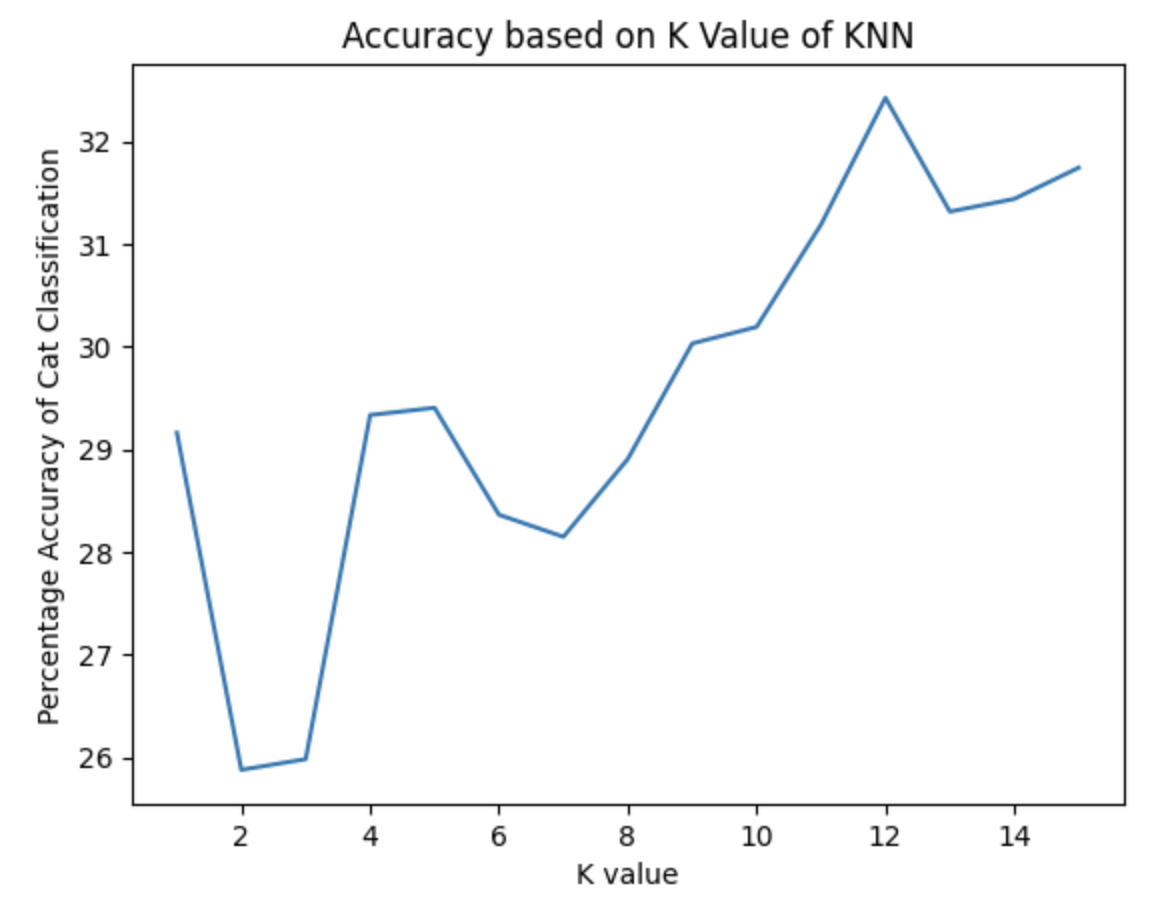

## References & Citations

Used tensorflow to load the CIFAR-10 dataset for KNN method https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data


Referenced to loop through different k values for KNN
https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

Used code from pytorch tutorial for implementation of the CNN https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html